In [3]:
import pandas as pd
import math
import random
import os
os.chdir("C:\\Users\\zaid0\\Documents\\R\\CM121")

In [4]:
# read in data and global variables
reads = pd.read_table("HW1\\Data\\reads.tsv", sep = "\t")
errors = pd.read_table("HW1\\Data\\errors.tsv", sep = "\t", header = None)
transitions = pd.read_table("HW1\\Data\\transitions.tsv", sep = "\t", header = None)
pAA = 0.95**2
pTT = 0.05**2
pAT = 1 - (pAA + pTT)

In [6]:
# function that generates posterior probabilities for a strictly biallelic model, assuming P(S = A) = P(S = B)
def posteriorProbs(df, A, B, pAA, pBB, pAB):
    # generate log liklihoods for each genotype
    llAA = 0
    llBB = 0
    llAB = 0
    for i in range(len(df)):
        O = df.at[i, 'observations']
        E = df.at[i, 'probability_of_error']
        if O == A:
            E = 1 - E
        llAA += math.log(E)
        llBB += math.log(1 - E) # all error probabilities are just the complement of the AA genotype's
        llAB += math.log(0.5) # read's likelihood simplifies to 0.5 under assumption that P(S = A) = P(S = B)
    # calculate denominator of Bayes' theorem equation
    d = math.exp(llAA + math.log(pAA)) + math.exp(llBB + math.log(pBB)) + math.exp(llAB + math.log(pAB))
    # calculate posterior probabilities for each genotype
    ppAA = math.exp(llAA + math.log(pAA) - math.log(d))
    ppBB = math.exp(llBB + math.log(pBB) - math.log(d))
    ppAB = math.exp(llAB + math.log(pAB) - math.log(d))
    return [ppAA, ppBB, ppAB]

In [7]:
# 2.b
print(posteriorProbs(reads, "A", "T", pAA, pTT, pAT))

[4.566267927307039e-300, 6.963414923108035e-290, 1.0]


In [8]:
# 2.c
size = 5
sample = reads.sample(n = size, random_state = 123)
sample.index = range(size)
print(posteriorProbs(sample, "A", "T", pAA, pTT, pAT))

[0.7450913796442712, 0.00012183530699187445, 0.25478678504873675]


<AxesSubplot: ylabel='Frequency'>

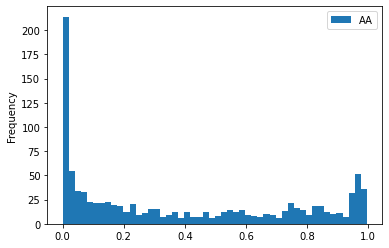

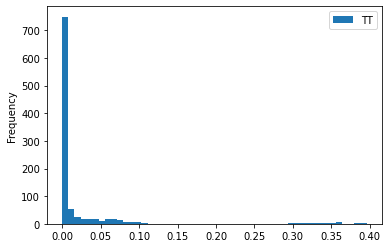

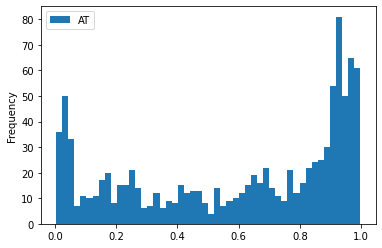

In [9]:
#2.d
size = 5
bootstrap1 = pd.DataFrame(
            {"AA" : [],
             "TT" : [],
             "AT" : []}
            )
for i in range(1000):
    sample = reads.sample(n = size, random_state = i) # setting seed ensures reproducibility
    sample.index = range(size)
    pp = posteriorProbs(sample, "A", "T", pAA, pTT, pAT)
    df = pd.DataFrame(
            {"AA" : [pp[0]],
             "TT" : [pp[1]],
             "AT" : [pp[2]]}
        )
    bootstrap1 = pd.concat([bootstrap1, df], axis = 0)
    
bootstrap1[["AA"]].plot.hist(bins = 50)
bootstrap1[["TT"]].plot.hist(bins = 50)
bootstrap1[["AT"]].plot.hist(bins = 50)

<AxesSubplot: ylabel='Frequency'>

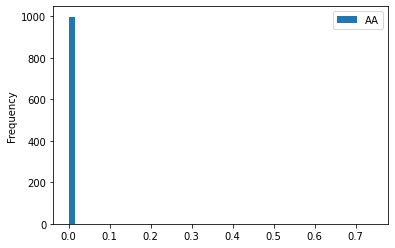

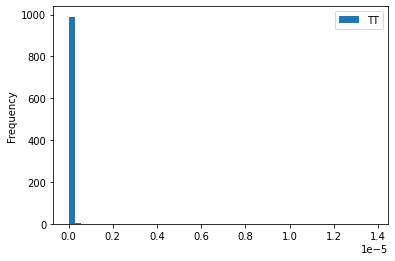

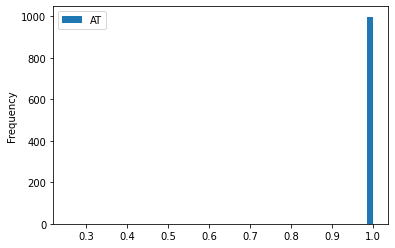

In [10]:
#2.e
size = 50
bootstrap2 = pd.DataFrame(
            {"AA" : [],
             "TT" : [],
             "AT" : []}
            )
for i in range(1000):
    sample = reads.sample(n = size, random_state = i) # setting seed ensures reproducibility
    sample.index = range(size)
    pp = posteriorProbs(sample, "A", "T", pAA, pTT, pAT)
    df = pd.DataFrame(
            {"AA" : [pp[0]],
             "TT" : [pp[1]],
             "AT" : [pp[2]]}
        )
    bootstrap2 = pd.concat([bootstrap2, df], axis = 0)
    
bootstrap2[["AA"]].plot.hist(bins = 50)
bootstrap2[["TT"]].plot.hist(bins = 50)
bootstrap2[["AT"]].plot.hist(bins = 50)

In [11]:
# 2.f
print("n = 5\n", bootstrap1.describe(), "\n")
print("n = 50\n", bootstrap2.describe())

n = 5
                 AA            TT           AT
count  1000.000000  1.000000e+03  1000.000000
mean      0.379180  2.153111e-02     0.599289
std       0.358881  6.432726e-02     0.342394
min       0.000001  2.423744e-11     0.003942
25%       0.032795  4.474481e-05     0.258711
50%       0.247731  6.918706e-04     0.694837
75%       0.741013  7.939751e-03     0.920067
max       0.996058  3.960132e-01     0.997807 

n = 50
                  AA            TT           AT
count  1.000000e+03  1.000000e+03  1000.000000
mean   8.702660e-04  3.796095e-08     0.999130
std    2.380412e-02  5.666851e-07     0.023804
min    2.419458e-28  4.713025e-30     0.257545
25%    1.076320e-17  3.289499e-19     1.000000
50%    5.672024e-15  2.286746e-16     1.000000
75%    5.644029e-12  1.658024e-13     1.000000
max    7.424545e-01  1.376403e-05     1.000000


In [73]:
# generates reads for a biallelic model, with the option to account for transitions or not
def generateReads(N, A, B, transition = True):
    result = pd.DataFrame(
            {"observations" : [],
             "probability_of_error" : [],
             "error_truth" : []}
        )
    bases = {"A" : 0, "C" : 1, "G" : 2, "T" : 3} # dictionary to help with indexing into transitions
    for n in range(N):
        # choose an allele to sample from
        S = random.randint(0, 1)
        # decide whether an error occured depending on the position k along the read
        k = random.randint(0, 99)
        e = errors.iat[k, 0]
        E = random.choices([0, 1], weights = [1 - e, e])[0]
        # if you sampled the major allele and there was no error
        if S == 0 and E == 0:
            O = A
            T = 0
        # if you sampled the minor allele and there was no error
        elif S == 1 and E == 0:
            O = B
            T = 0
        # if you sampled the major allele and there was an error
        elif S == 0 and E == 1:
            if transition:
                w = list(transitions.iloc[bases[A]])
                O = random.choices(list(bases.keys()), weights = w)[0]
            else:
                O = B
        # if you sampled the minor allele and there was an error
        elif S == 1 and E == 1:
            if transition:
                w = list(transitions.iloc[bases[B]])
                O = random.choices(list(bases.keys()), weights = w)[0]
            else:
                O = A
        df = pd.DataFrame(
            {"observations" : [O],
             "probability_of_error" : [e],
             "error_truth" : ["True" if (E == 1) else "False"]}
        )
        result = pd.concat([result, df], axis = 0)
    result.index = range(N)
    return(result)

def posteriorProbs2(df, A, B, pAA, pBB, pAB):
    # generate log liklihoods for each genotype
    llAA = 0
    llBB = 0
    llAB = 0
    bases = {"A" : 0, "C" : 1, "G" : 2, "T" : 3} # dictionary to help with indexing into transitions
    for i in range(len(df)):
        O = df.at[i, 'observations']
        E = df.at[i, 'probability_of_error']
        T_A = transitions.iat[bases[A], bases[O]] # probability of a transition from the major allele to the observation
        T_B = transitions.iat[bases[B], bases[O]] # probability of a transition from the minor allele to the observation
        # if the base is the major allele
        if O == A:
            llAA += math.log(1 - E)
            llBB += math.log(E * T_B)
            llAB += math.log((1 - E) * 0.5 + (E * T_B) * 0.5)
        # if the base is the minor allele
        elif O == B:
            llAA += math.log(E * T_A)
            llBB += math.log(1 - E)
            llAB += math.log((E * T_A) * 0.5 + (1 - E) * 0.5)
        # if the base is neither
        else:
            llAA += math.log(E * T_A)
            llBB += math.log(E * T_B)
            llAB += math.log((E * T_A) * 0.5 + (E * T_B) * 0.5)
    # calculate denominator of Bayes' theorem equation
    d = math.exp(llAA + math.log(pAA)) + math.exp(llBB + math.log(pBB)) + math.exp(llAB + math.log(pAB))
    # calculate posterior probabilities for each genotype
    ppAA = math.exp(llAA + math.log(pAA) - math.log(d))
    ppBB = math.exp(llBB + math.log(pBB) - math.log(d))
    ppAB = math.exp(llAB + math.log(pAB) - math.log(d))
    return [ppAA, ppBB, ppAB]

# Example with a fixed genotype of AT
random.seed(123)
df = generateReads(N = 20, A = "A", B = "T")
posteriorProbs2(df, A = "A", B = "T", pAA = pAA, pBB = pTT, pAB = pAT)

[5.151552673764379e-11, 7.162852210144656e-07, 0.9999992836632651]

<AxesSubplot: ylabel='Frequency'>

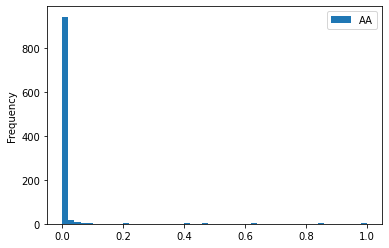

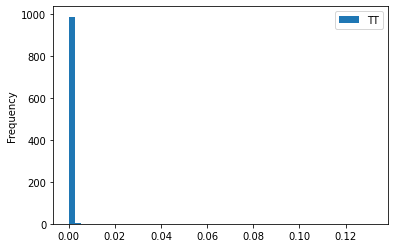

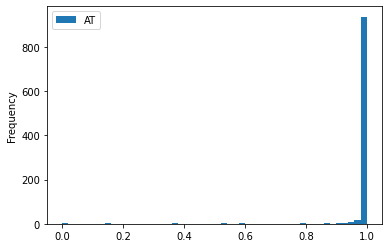

In [77]:
# 3.c.2 - posterior probability simulations and histogram
simulation = pd.DataFrame(
            {"AA" : [],
             "TT" : [],
             "AT" : []}
            )
for i in range(1000):
    # we're going to fix a true genotype AT
    random.seed(i)
    sample = generateReads(N = 20, A = "A", B = "T")
    pp = posteriorProbs2(sample, "A", "T", pAA, pTT, pAT) # posteriorProbs2 is able to account for transitions
    df = pd.DataFrame(
            {"AA" : [pp[0]],
             "TT" : [pp[1]],
             "AT" : [pp[2]]}
        )
    simulation = pd.concat([simulation, df], axis = 0)
    
simulation[["AA"]].plot.hist(bins = 50)
simulation[["TT"]].plot.hist(bins = 50)
simulation[["AT"]].plot.hist(bins = 50)

In [78]:
# 3.c.3 probability for each genotype
simulation.mean()

AA    0.016478
TT    0.000529
AT    0.982993
dtype: float64

<AxesSubplot: ylabel='Frequency'>

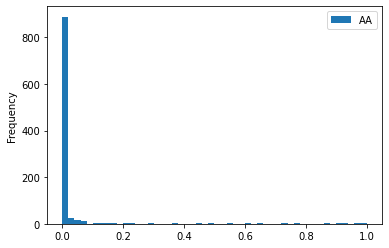

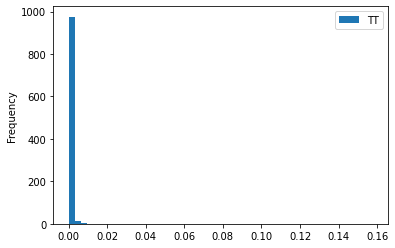

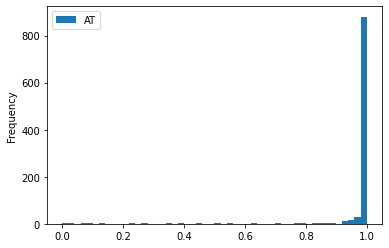

In [81]:
# 3.d.1 - posterior probability simulations and histogram
simulation2 = pd.DataFrame(
            {"AA" : [],
             "TT" : [],
             "AT" : []}
            )
for i in range(1000):
    # we're going to fix a true genotype AT
    random.seed(i)
    sample = generateReads(N = 20, A = "A", B = "T", transition = False)
    pp = posteriorProbs(sample, "A", "T", pAA, pTT, pAT) # posteriorProbs has no dependency on transitions
    df = pd.DataFrame(
            {"AA" : [pp[0]],
             "TT" : [pp[1]],
             "AT" : [pp[2]]}
        )
    simulation2 = pd.concat([simulation2, df], axis = 0)
    
simulation2[["AA"]].plot.hist(bins = 50)
simulation2[["TT"]].plot.hist(bins = 50)
simulation2[["AT"]].plot.hist(bins = 50)

In [82]:
# 3.d.2 - probability for each genotype
simulation2.mean()

AA    0.035528
TT    0.000627
AT    0.963845
dtype: float64